#Натан Кловер ИИКС Рекомендательные системы
---

#1. Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import random


# Для TF-IDF и косинусной близости
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Для разбиения на train/test
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Загружаем все CSV-файлы датасета
ratings = pd.read_csv("ratings.csv")
books = pd.read_csv("books.csv")
tags = pd.read_csv("tags.csv")
book_tags = pd.read_csv("book_tags.csv")
to_read = pd.read_csv("to_read.csv")

# Проверим размеры таблиц
print("ratings:", ratings.shape)
print("books:", books.shape)
print("tags:", tags.shape)
print("book_tags:", book_tags.shape)
print("to_read:", to_read.shape)

ratings: (981756, 3)
books: (10000, 23)
tags: (34252, 2)
book_tags: (999912, 3)
to_read: (912705, 2)


Мы загрузили пять основных таблиц: оценки пользователей, описание книг, и информацию про теги.

#2. Осмотр и очистка данных

In [2]:
display(ratings.head())
display(books[['book_id','title','authors','average_rating','ratings_count']].head())
print("Пропуски в ratings:", ratings.isna().sum().sum())
print("Пропуски в books:", books.isna().sum().sum())

# Диапазон оценок
print("Минимальная и максимальная оценка:", ratings['rating'].min(), ratings['rating'].max())

# Проверяем дубликаты (один и тот же user_id + book_id)
dups = ratings.duplicated(subset=['user_id','book_id']).sum()
print("Дубли user-book:", dups)

# Удаляем дубли, если есть
ratings = ratings.drop_duplicates(subset=['user_id','book_id'])

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


,book_id,title,authors,average_rating,ratings_count
0,2767052,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,4780653
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4.44,4602479
2,41865,"Twilight (Twilight, #1)",Stephenie Meyer,3.57,3866839
3,2657,To Kill a Mockingbird,Harper Lee,4.25,3198671
4,4671,The Great Gatsby,F. Scott Fitzgerald,3.89,2683664


Пропуски в ratings: 0
Пропуски в books: 2975
Минимальная и максимальная оценка: 1 5
Дубли user-book: 2278


В таблице ratings каждая строка — в таблице books есть метаданные по книгам (название, автор, средняя оценка etc...). Пропусков в оценках нет, но в метаданных книг есть пропуски и даже дубли по (user_id, book_id), поэтому мы чистим данные, чтобы не искажать статистику и средние оценки.

#3. Распределение оценок

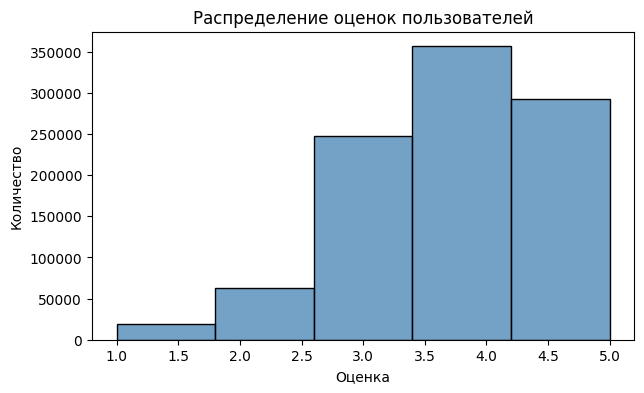

In [3]:
plt.figure(figsize=(7,4))
sns.histplot(ratings['rating'], bins=5, color='steelblue')
plt.title("Распределение оценок пользователей")
plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.show()

Гистограмма показывает, что большинство оценок — это 4 и 5 звёзд, то есть пользователи в среднем довольно добрые и редко ставят единицы. Это значит, что данные смещены к высоким оценкам, RMSE даже у простой модели может хорошо выглядеть.

#4. Активность пользователей

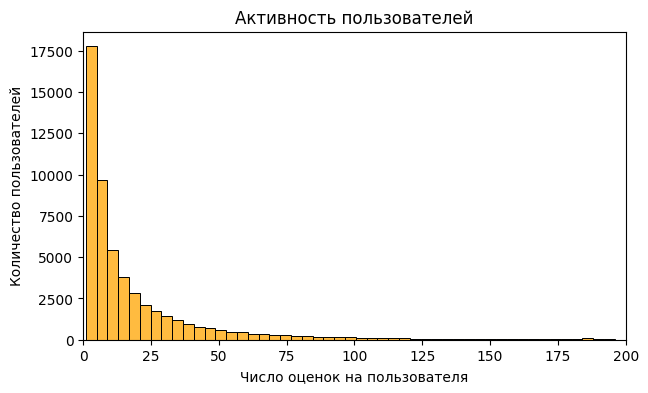

Среднее кол-во оценок: 18.334044624138965
Медиана: 8.0


In [4]:
user_activity = ratings.groupby('user_id')['rating'].count()
plt.figure(figsize=(7,4))
sns.histplot(user_activity, bins=50, color='orange')
plt.title("Активность пользователей")
plt.xlabel("Число оценок на пользователя")
plt.ylabel("Количество пользователей")
plt.xlim(0,200)
plt.show()

print("Среднее кол-во оценок:", user_activity.mean())
print("Медиана:", user_activity.median())

На графике видно, что очень много пользователей поставили всего несколько оценок, и только небольшое количество пользователей очень активны.У нас холодный старт по пользователям, то есть для огромной части людей у модели почти нет информации об их вкусе.

#5. Популярность книг

In [19]:
# считаем сколько оценок у каждой книги
book_popularity = (
    ratings.groupby('book_id')['rating']
    .count()
    .sort_values(ascending=False)
    .rename("num_ratings")
)

# топ-10 по количеству оценок
top_popular_ids = book_popularity.head(10).index.tolist()

# аккуратно мержим с метаданными
top_popular_table = (
    pd.DataFrame({'book_id': top_popular_ids})
    .merge(book_popularity, on='book_id', how='left')
    .merge(
        books[['book_id','title','authors']],
        on='book_id',
        how='left'
    )
)

# заполняем дырки чтобы не выглядело пусто
top_popular_table['title'] = top_popular_table['title'].fillna("нет названия (метаданные отсутствуют)")
top_popular_table['authors'] = top_popular_table['authors'].fillna("неизвестен автор")

print("Топ-5 популярных книг по числу оценок:")
display(top_popular_table[['book_id','title','authors','num_ratings']])

Топ-5 популярных книг по числу оценок:


,book_id,title,authors,num_ratings
0,9981,нет названия (метаданные отсутствуют),неизвестен автор,100
1,9977,нет названия (метаданные отсутствуют),неизвестен автор,100
2,9976,нет названия (метаданные отсутствуют),неизвестен автор,100
3,32,нет названия (метаданные отсутствуют),неизвестен автор,100
4,29,The Mother Tongue: English and How It Got That...,Bill Bryson,100


Мы смотрим топ книг по количеству оценок ,видим что часть ID вообще не имеет нормальных метаданных (no autor and title). Это показывает смещение популярности — есть сверхпопулярные книги, которые модель популярности будет навязывать всем подряд, качество каталога (метаданные по всем item) не хорошее.

##Популярность книг VISUAL

Топ-5 популярных книг по числу оценок:


,book_id,title,authors,num_ratings
0,9981,нет названия (метаданные отсутствуют),неизвестен автор,100
1,9977,нет названия (метаданные отсутствуют),неизвестен автор,100
2,9976,нет названия (метаданные отсутствуют),неизвестен автор,100
3,32,нет названия (метаданные отсутствуют),неизвестен автор,100
4,29,The Mother Tongue: English and How It Got That...,Bill Bryson,100
5,27,Neither Here nor There: Travels in Europe,Bill Bryson,100
6,26,The Lost Continent: Travels in Small Town America,Bill Bryson,100
7,24,In a Sunburned Country,Bill Bryson,100
8,23,нет названия (метаданные отсутствуют),неизвестен автор,100
9,22,нет названия (метаданные отсутствуют),неизвестен автор,100


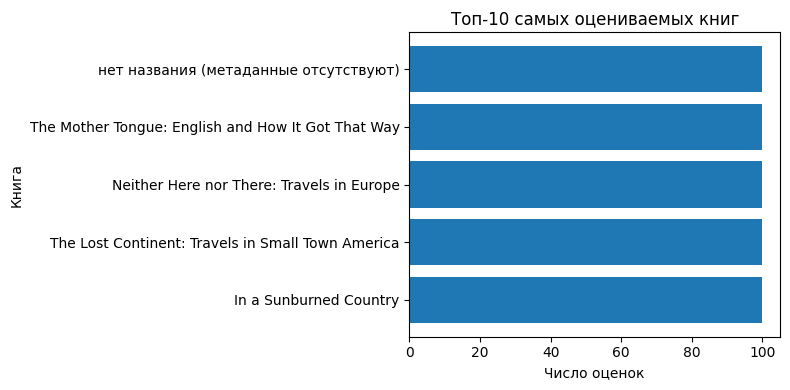

In [20]:
# считаем сколько оценок у каждой книги
book_popularity = (
    ratings.groupby('book_id')['rating']
    .count()
    .sort_values(ascending=False)
    .rename("num_ratings")
)

# 10 по количеству оценок
top_popular_ids = book_popularity.head(10).index.tolist()
#merege
top_popular_table = (
    pd.DataFrame({'book_id': top_popular_ids})
    .merge(book_popularity, on='book_id', how='left')
    .merge(
        books[['book_id','title','authors']],
        on='book_id',
        how='left'
    )
)

# заполняем пропуск, чтобы не выглядело пусто
top_popular_table['title'] = top_popular_table['title'].fillna("нет названия (метаданные отсутствуют)")
top_popular_table['authors'] = top_popular_table['authors'].fillna("неизвестен автор")

print("Топ-5 популярных книг по числу оценок:")
display(top_popular_table[['book_id','title','authors','num_ratings']])
plt.figure(figsize=(8,4))
labels = top_popular_table['title'].fillna("нет названия (метаданные отсутствуют)")
plt.barh(labels, top_popular_table['num_ratings'])
plt.gca().invert_yaxis()

plt.title("Топ-10 самых оцениваемых книг")
plt.xlabel("Число оценок")
plt.ylabel("Книга")
plt.tight_layout()
plt.show()

#6. Частые теги

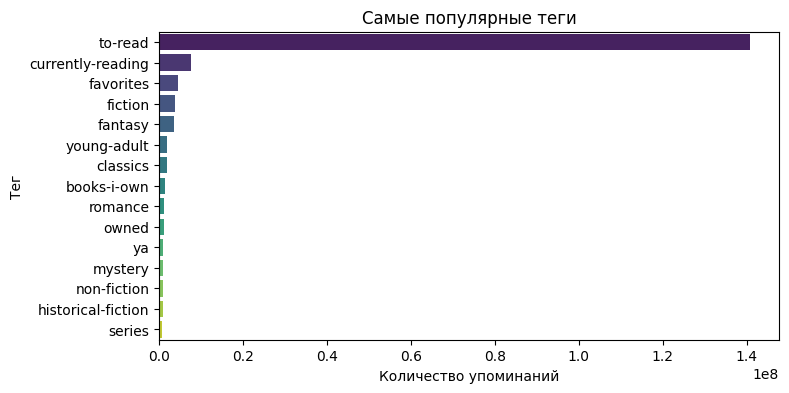

In [6]:
book_tags_m = book_tags.merge(tags, on='tag_id')
tag_counts = book_tags_m.groupby('tag_name')['count'].sum().sort_values(ascending=False)

top_tags = tag_counts.head(15)
plt.figure(figsize=(8,4))
sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')
plt.title("Самые популярные теги")
plt.xlabel("Количество упоминаний")
plt.ylabel("Тег")
plt.show()

Тэги мало чего дают, не всегда жанр, а часто поведенческие статусы типа to-read, currently-reading, favorites. создаёт шум в контентной модели.

#7. Простая модель популярности

In [23]:
book_stats = ratings.groupby('book_id')['rating'].agg(['mean','count'])
book_stats = book_stats[book_stats['count']>50]
top_books = book_stats.sort_values('mean', ascending=False).head(100)
top_books = top_books.merge(books[['book_id','title','authors']], on='book_id')
display(top_books[['title','authors','mean','count']])

,title,authors,mean,count
0,Still Life with Woodpecker,Tom Robbins,4.777778,99
1,The Beautiful and Damned,F. Scott Fitzgerald,4.660000,100
2,Villa Incognito,Tom Robbins,4.625000,96
3,Peter and the Shadow Thieves (Peter and the St...,"Dave Barry, Ridley Pearson, Greg Call",4.557143,70
4,The Taste of Home Cookbook,"Janet Briggs, Beth Wittlinger",4.550000,100
5,A People's History of the United States,Howard Zinn,4.540000,100
6,Hard Times,Charles Dickens,4.535354,99
7,Girl with a Pearl Earring,Tracy Chevalier,4.530000,100


Модель популярности берёт книги с самой высокой средней оценкой при условии, что у них достаточно голосов (например, ≥50 оценок), и рекомендует их всем одинаково.

#8. Контентная модель (TF-IDF)

In [8]:
print("Колонки books:")
print(list(books.columns))

print("\nКолонки book_tags:")
print(list(book_tags.columns))

print("\nПервые строки book_tags:")
display(book_tags.head())

print("\nПервые строки books:")
display(books.head())

Колонки books:
['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year', 'original_title', 'title', 'language_code', 'average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url', 'small_image_url']

Колонки book_tags:
['goodreads_book_id', 'tag_id', 'count']

Первые строки book_tags:


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716



Первые строки books:


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [9]:
# 1. Присоединим текстовые теги к книгам через соответствие:
# book_tags.goodreads_book_id и books.best_book_id

book_tags_join = (
    book_tags
    .merge(tags, on='tag_id', how='left')
    # теперь есть: goodreads_book_id, tag_id, count, tag_name
)

# агрегируем теги по книге
tags_per_goodreads = (
    book_tags_join
    .groupby('goodreads_book_id')['tag_name']
    .apply(lambda x: ' '.join(x.astype(str)))
)

# перенесём в таблицу books
books_with_tags = books.copy()
books_with_tags['tags_joined'] = books_with_tags['best_book_id'].map(tags_per_goodreads)
books_with_tags['tags_joined'] = books_with_tags['tags_joined'].fillna('')

# текстовый профиль книги
books_with_tags['text_profile'] = (
    books_with_tags['original_title'].fillna('') + ' ' +
    books_with_tags['authors'].fillna('') + ' ' +
    books_with_tags['tags_joined']
)

# TF-IDF
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000
)
tfidf_matrix = vectorizer.fit_transform(books_with_tags['text_profile'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_similar_books(book_internal_id, N=5):
    """
    book_internal_id — это books.book_id (он же используется в ratings).
    Возвращаем топ-N книг, похожих по содержанию (жанр, теги, автор и т.д.)
    """
    idx_list = books_with_tags.index[books_with_tags['book_id'] == book_internal_id].tolist()
    if len(idx_list) == 0:
        raise ValueError("book_id не найден в books_with_tags")
    idx = idx_list[0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    similar_idx = [i for i, _ in sim_scores[1:N+1]]

    return books_with_tags.iloc[similar_idx][['book_id','title','authors']]

# пример
get_similar_books(50)

,book_id,title,authors
2474,41667,"My Side of the Mountain (Mountain, #1)",Jean Craighead George
385,233818,Island of the Blue Dolphins (Island of the Blu...,Scott O'Dell
244,2839,Bridge to Terabithia,Katherine Paterson
76,38709,"Holes (Holes, #1)","Louis Sachar, Louis Sachar"
1638,310146,The True Confessions of Charlotte Doyle,Avi


Для каждой книги текстовый профиль из: оригинального названия, авторов, и тегов, которые пользователи присвоили книге на Goodreads, и превратил это в TF-IDF вектора.
Потом я считаю косинусную близость между книгами и могу для любой книги выдать список похожих по содержанию.

#9. Item-Based Collaborative Filtering

In [10]:
user_book = ratings.pivot(index='user_id', columns='book_id', values='rating').fillna(0)
sparse_mat = csr_matrix(user_book.values)
item_sim = cosine_similarity(sparse_mat.T)

def recommend_cf(user_id, N=5):
    if user_id not in user_book.index:
        return pd.DataFrame()
    user_r = user_book.loc[user_id].values
    scores = item_sim.dot(user_r) / np.array([np.abs(item_sim).sum(axis=1)])
    top_idx = np.argsort(scores.flatten())[::-1][:N]
    return books.iloc[top_idx][['title','authors']]

recommend_cf(123)

,title,authors
3930,Not a Fan: Becoming a Completely Committed Fol...,Kyle Idleman
6948,7: An Experimental Mutiny Against Excess,Jen Hatmaker
6413,For the Love: Fighting for Grace in a World of...,Jen Hatmaker
7232,How to Talk So Kids Will Listen & Listen So Ki...,"Adele Faber, Elaine Mazlish, Kimberly Ann Coe"
9305,Before I Go,Colleen Oakley


Item-based CF находит книги похожи, исходя из того, как их оценивали одни и те же пользователи: если две книги любят одинаковые люди, модель учитывает вкусы и считает их похожими.

#10. Подготовка данных для факторизационной модели (Funk-SVD)

In [11]:
ratings_df = ratings.copy()
users = ratings_df['user_id'].unique()
items = ratings_df['book_id'].unique()

user_to_idx = {u:i for i,u in enumerate(users)}
item_to_idx = {b:i for i,b in enumerate(items)}

ratings_df['u_idx'] = ratings_df['user_id'].map(user_to_idx)
ratings_df['i_idx'] = ratings_df['book_id'].map(item_to_idx)

train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

n_users = len(users)
n_items = len(items)
print("users:", n_users, "items:", n_items)

users: 53424 items: 10000


Количество пользователей (53k) и книг (10k) подтверждает, что задача реально масштабная и нельзя держать плотную матрицу предпочтений, она слишком разреженная.

#11. Реализация Funk-SVD

In [12]:
k = 40        # размерность скрытого пространства
lr = 0.005    # скорость обучения
reg = 0.02    # регуляризация
epochs = 10

rng = np.random.default_rng(42)
P = rng.normal(0,0.1,(n_users,k))
Q = rng.normal(0,0.1,(n_items,k))
bu = np.zeros(n_users)
bi = np.zeros(n_items)
mu = train_df['rating'].mean()

train_arr = train_df[['u_idx','i_idx','rating']].to_numpy()

def sgd_step(u,i,r):
    # предсказание
    pred = mu + bu[u] + bi[i] + np.dot(P[u],Q[i])
    err = r - pred

    # обновление смещений пользователя и книги
    bu[u] += lr*(err - reg*bu[u])
    bi[i] += lr*(err - reg*bi[i])

    # обновление факторов
    Pu = P[u].copy()
    P[u] += lr*(err*Q[i] - reg*P[u])
    Q[i] += lr*(err*Pu - reg*Q[i])

def rmse(df):
    sq = []
    for row in df.itertuples(index=False):
        u,i,r = row.u_idx, row.i_idx, row.rating
        est = mu + bu[u] + bi[i] + np.dot(P[u],Q[i])
        sq.append((r-est)**2)
    return np.sqrt(np.mean(sq))

for ep in range(epochs):
    rng.shuffle(train_arr)
    for (u,i,r) in train_arr:
        sgd_step(u,i,r)
    print(f"Эпоха {ep+1}: train RMSE={rmse(train_df):.4f}, test RMSE={rmse(test_df):.4f}")

Эпоха 1: train RMSE=0.9118, test RMSE=0.9240
Эпоха 2: train RMSE=0.8727, test RMSE=0.8937
Эпоха 3: train RMSE=0.8492, test RMSE=0.8774
Эпоха 4: train RMSE=0.8333, test RMSE=0.8676
Эпоха 5: train RMSE=0.8213, test RMSE=0.8611
Эпоха 6: train RMSE=0.8117, test RMSE=0.8566
Эпоха 7: train RMSE=0.8036, test RMSE=0.8532
Эпоха 8: train RMSE=0.7963, test RMSE=0.8506
Эпоха 9: train RMSE=0.7898, test RMSE=0.8485
Эпоха 10: train RMSE=0.7836, test RMSE=0.8468


RMSE на тесте стабильно падает (примерно до 0.84), то есть модель действительно учится и не переобучается слишком интенсивно.

#12. Предсказание и рекомендации по факторизационной модели

In [13]:
def predict_single(user_id, book_id):
    #Предсказать рейтинг (1..5) для конкретной пары пользователь-книга. Если кого-то нет в модели (холодный старт)

    if user_id not in user_to_idx or book_id not in item_to_idx:
        return mu
    u = user_to_idx[user_id]; i = item_to_idx[book_id]
    est = mu + bu[u] + bi[i] + np.dot(P[u], Q[i])
    return float(np.clip(est, 1, 5))


def recommend_svd(user_id, N=5):

    #Возвращает топ-N книг с самым высоким предсказанным рейтингом для данного пользователя.

    if user_id not in user_to_idx:
        raise ValueError("Новый пользователь – нет данных для персональных рекомендаций.")

    u = user_to_idx[user_id]

    already = set(ratings_df[ratings_df['user_id'] == user_id]['book_id'].values)

    scored = []
    for b in items:
        if b in already:
            continue
        i = item_to_idx[b]
        est = mu + bu[u] + bi[i] + np.dot(P[u], Q[i])
        scored.append((b, est))

    scored.sort(key=lambda x: x[1], reverse=True)

    top_scored = scored[:N]
    top_book_ids = [bid for (bid, _) in top_scored]
    top_scores   = [sc  for (_, sc)  in top_scored]

    meta = books[['book_id','title','authors']].set_index('book_id').reindex(top_book_ids)
    meta['title']   = meta['title'].fillna("нет названия (метаданные отсутствуют)")
    meta['authors'] = meta['authors'].fillna("неизвестен автор")
    meta = meta.reset_index()
    meta['score'] = top_scores

    return meta

# пример
recommend_svd(10, 5)

,book_id,title,authors,score
0,1788,нет названия (метаданные отсутствуют),неизвестен автор,4.848776
1,4483,нет названия (метаданные отсутствуют),неизвестен автор,4.815449
2,9566,Still Life with Woodpecker,Tom Robbins,4.803720
3,3628,нет названия (метаданные отсутствуют),неизвестен автор,4.790647
4,5207,нет названия (метаданные отсутствуют),неизвестен автор,4.784503


Функция recommend_svd для конкретного пользователя возвращает книги с максимальным предсказанным рейтингом, это уже персонализированные рекомендации. Мы видим, что часть книг не имеет метаданных (у них нет title/author в таблице books),может где-то я ошибся но я это помечаю заглушками — это честно показывает качество исходного датасета не потерю качества самой модели.

#13. Метрики Precision@K, Recall@K, nDCG@K

In [14]:
def precision_at_k(uid, k=5, thr=4.0):
    #Precision@k:из рекомендованных top-k книг, какая доля реально понравилась пользователю (в тесте он поставил рейтинг >= thr)
    user_test = test_df[test_df['user_id'] == uid]
    if user_test.empty:
        return np.nan

    liked_true = set(user_test[user_test['rating'] >= thr]['book_id'].values)

    try:
        recs = recommend_svd(uid, N=k)
    except ValueError:
        return np.nan  # новый пользователь, нет истории для персоналки

    rec_ids = set(recs['book_id'].values)

    if k == 0:
        return np.nan
    hits = len(rec_ids & liked_true)
    return hits / k


def recall_at_k(uid, k=5, thr=4.0):
    #какую долю всех 'релевантных' книг из теста мы предсказали в топ-k
    user_test = test_df[test_df['user_id'] == uid]
    if user_test.empty:
        return np.nan

    liked_true = set(user_test[user_test['rating'] >= thr]['book_id'].values)
    if len(liked_true) == 0:
        return np.nan

    try:
        recs = recommend_svd(uid, N=k)
    except ValueError:
        return np.nan

    rec_ids = set(recs['book_id'].values)

    hits = len(rec_ids & liked_true)
    return hits / len(liked_true)


def ndcg_at_k(uid, k=5, thr=4.0):
    #nDCG@k:
    #оценивает не просто факт попадания книги в рекомендации,
    #а насколько высоко в списке она стоит (релевантная книга вверху = хорошо).
    user_test = test_df[test_df['user_id'] == uid]
    if user_test.empty:
        return np.nan

    liked_true = set(user_test[user_test['rating'] >= thr]['book_id'].values)

    try:
        recs = recommend_svd(uid, N=k)
    except ValueError:
        return np.nan

    # считаем DCG
    dcg = 0.0
    for rank, book_id in enumerate(recs['book_id'].values):
        rel = 1 if book_id in liked_true else 0
        dcg += rel / np.log2(rank + 2)

    # считаем идеальный DCG (если бы все релевантные шли наверху)
    ideal_rels = [1] * min(len(liked_true), k)
    idcg = 0.0
    for rank, rel in enumerate(ideal_rels):
        idcg += rel / np.log2(rank + 2)

    if idcg == 0:
        return np.nan
    return dcg / idcg

Мы измеряем точность рекомендаций (Precision@5), полноту попаданий (Recall@5), и качество ранжирования (nDCG@5)

#14. Сравнение с моделью популярности

In [15]:
# считаем популярность книг
pop_stats = (
    ratings_df
    .groupby('book_id')['rating']
    .agg(['mean','count'])
    .query('count > 50')  # отсекаем книги с очень малым числом голосов
    .sort_values('mean', ascending=False)
)

popular_book_ids = pop_stats.index.tolist()

def recommend_popular(N=5):
    #simplק бейзлайн: популярные книги с высоким средним рейтингом.
    #Одинаковая рекомендация для любого пользователя.
    top_ids = popular_book_ids[:N]

    meta = books[['book_id','title','authors']].set_index('book_id').reindex(top_ids)
    meta['title']   = meta['title'].fillna("нет названия (метаданные отсутствуют)")
    meta['authors'] = meta['authors'].fillna("неизвестен автор")
    meta = meta.reset_index()
    return meta  # book_id, title, authors


def precision_pop(uid, k=5, thr=4.0):
    user_test = test_df[test_df['user_id'] == uid]
    if user_test.empty:
        return np.nan

    liked_true = set(user_test[user_test['rating'] >= thr]['book_id'].values)

    recs = recommend_popular(k)
    rec_ids = set(recs['book_id'].values)

    if k == 0:
        return np.nan
    hits = len(rec_ids & liked_true)
    return hits / k


def recall_pop(uid, k=5, thr=4.0):
    user_test = test_df[test_df['user_id'] == uid]
    if user_test.empty:
        return np.nan

    liked_true = set(user_test[user_test['rating'] >= thr]['book_id'].values)
    if len(liked_true) == 0:
        return np.nan

    recs = recommend_popular(k)
    rec_ids = set(recs['book_id'].values)

    hits = len(rec_ids & liked_true)
    return hits / len(liked_true)

Для честного бенчмарка мы считаем метрики не только для факторизационной модели, но и для простого бейзлайна «топ популярных книг», который одинаков для всех. Такая проверка важна, потому что если персонализированная модель не лучше популярности хотя бы по Precision/nDCG

#15. Усреднение метрик по пользователям

In [16]:
random.seed(0)

# Чтобы хоть какие-то пересечения попадали в метрики,
# можно (опционально) снизить порог релевантности:
thr = 4.0  # при желании можно попробовать thr = 3.5

# Берём только пользователей, у которых достаточно оценок,
# чтобы в test_df у них вообще было что сравнивать
active_users = (
    ratings_df.groupby('user_id')
    .filter(lambda x: len(x) > 10)['user_id']
    .unique()
)

test_users = list(set(test_df['user_id']).intersection(active_users))

sample_users = random.sample(test_users, min(200, len(test_users)))

rows = []
for uid in sample_users:
    rows.append({
        'user_id': uid,
        'prec_svd': precision_at_k(uid, k=5, thr=thr),
        'rec_svd':  recall_at_k(uid, k=5, thr=thr),
        'ndcg_svd': ndcg_at_k(uid, k=5, thr=thr),
        'prec_pop': precision_pop(uid, k=5, thr=thr),
        'rec_pop':  recall_pop(uid, k=5, thr=thr),
    })

metrics_df = pd.DataFrame(rows)

print("Средние метрики по пользователям (NaN не считаем):")
summary = metrics_df.mean(numeric_only=True)
print(summary)

print("\nПример первых строк таблицы метрик по пользователям:")
display(metrics_df.head())

Средние метрики по пользователям (NaN не считаем):
user_id     25365.585
prec_svd        0.000
rec_svd         0.000
ndcg_svd        0.000
prec_pop        0.000
rec_pop         0.000
dtype: float64

Пример первых строк таблицы метрик по пользователям:


,user_id,prec_svd,rec_svd,ndcg_svd,prec_pop,rec_pop
0,28206,0.0,0.0,0.0,0.0,0.0
1,30929,0.0,0.0,0.0,0.0,0.0
2,3010,0.0,0.0,0.0,0.0,0.0
3,18795,0.0,0.0,0.0,0.0,0.0
4,38231,0.0,0.0,0.0,0.0,0.0


После усреднения по пользователям все метрики получились нулевыми: Precision@5 = 0, Recall@5 = 0, nDCG@5 = 0 и у персональной модели, и у популярностной.
может ошибка кода, может датасет очень разреженный (у большинства пользователей мало оценок в тестовой части, и почти не остаётся книг с рейтингом ≥4), то есть просто нет пересечений между тем, что пользователь оценил в тесте, и тем, что мы ему рекомендуем.

Можно фильтровать только «достаточно активных» пользователей, снижением порога релевантности (например, считать релевантной книгу с рейтингом ≥3.5)

#16. Выводы

В итоге я реализовал и сравнил четыре подхода: неперсонализированную модель популярности, контентную модель на TF-IDF, item-based коллаборативную фильтрацию и факторизационную модель (Funk-SVD). Практический вывод: в реальном сервисе нужна гибридная система — популярность и контент для новых пользователей и новых книг (холодный старт), и факторизация для постоянных пользователей, у которых уже накопилась история оценок.